Dataset --> https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia



'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
import zipfile

with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [ ]:
import os
import cv2
import pickle	# Used to save variables
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm	# Used to display progress bar
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 	# Used to generate images

In [ ]:
np.random.seed(22)

In [ ]:
# Do not forget to include the last slash
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))

    norm_images = []
    for image in tqdm(norm_files):
		# Read image
        image = cv2.imread(norm_path + image)
		# Resize image to 200x200 px
        image = cv2.resize(image, dsize=(200,200))
		# Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)

    norm_images = np.array(norm_images)

    return norm_images, norm_labels

In [ ]:
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])

    pneu_images = []
    for image in tqdm(pneu_files):
		# Read image
        image = cv2.imread(pneu_path + image)
		# Resize image to 200x200 px
        image = cv2.resize(image, dsize=(200,200))
		# Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)

    pneu_images = np.array(pneu_images)

    return pneu_images, pneu_labels

In [ ]:
print('Loading images')

Loading images


In [ ]:
# All images are stored in _images, all labels are in _labels
norm_images, norm_labels = load_normal('/content/dataset/chest_xray/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('/content/dataset/chest_xray/train/PNEUMONIA/')


100%|██████████| 3875/3875 [00:18<00:00, 211.08it/s]


In [ ]:
# Put all train images to X_train
X_train = np.append(norm_images, pneu_images, axis=0)

# Put all train labels to y_train
y_train = np.append(norm_labels, pneu_labels)

print(X_train.shape)
print(y_train.shape)

(5216, 200, 200)
(5216,)


In [ ]:
np.unique(y_train, return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2530, 1341, 1345]))

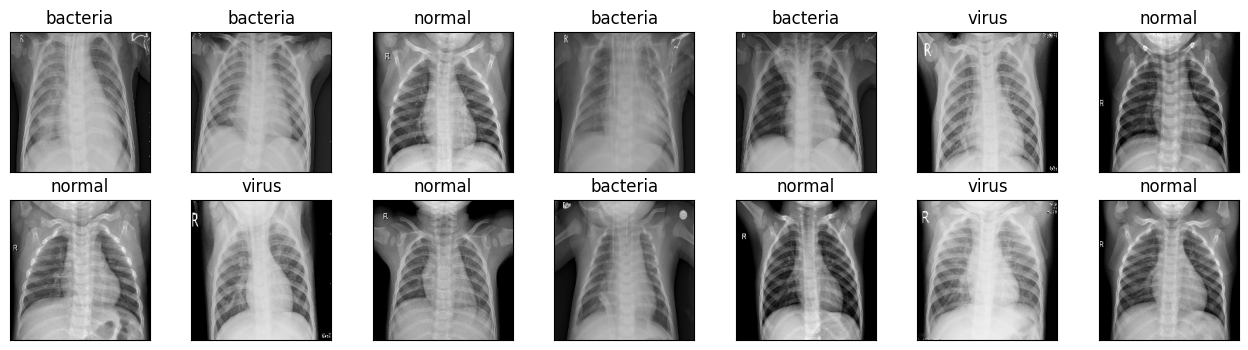

In [ ]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [ ]:
norm_images_test, norm_labels_test = load_normal('/content/dataset/chest_xray/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('//content/dataset/chest_xray/test/PNEUMONIA/')
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [00:01<00:00, 270.62it/s]


In [ ]:
# Use this to save variables
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)
# Use this to load variables
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [ ]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False)

In [ ]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1)

#Augmentation data

In [ ]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size=32)

In [ ]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1),
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1),
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1),
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1),
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit(train_gen, epochs=30,
          validation_data=(X_test, y_test_one_hot))

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - acc: 0.4977 - loss: 11.8032 - val_acc: 0.7003 - val_loss: 0.8485
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - acc: 0.7101 - loss: 0.6702 - val_acc: 0.6763 - val_loss: 1.0543
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - acc: 0.7331 - loss: 0.6265 - val_acc: 0.7484 - val_loss: 0.8475
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - acc: 0.7470 - loss: 0.5976 - val_acc: 0.7933 - val_loss: 0.7301
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - acc: 0.7449 - loss: 0.5905 - val_acc: 0.7821 - val_loss: 0.7848
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - acc: 0.7597 - loss: 0.5740 - val_acc: 0.7179 - val_loss: 1.0774
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - acc: 0.7501 - loss: 0.5877 - val_acc: 0.7308 - val_loss: 0.8156
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - acc: 0.7509 - loss: 0.5778 - val_acc: 0.7147 - val_loss: 1.0815
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 20

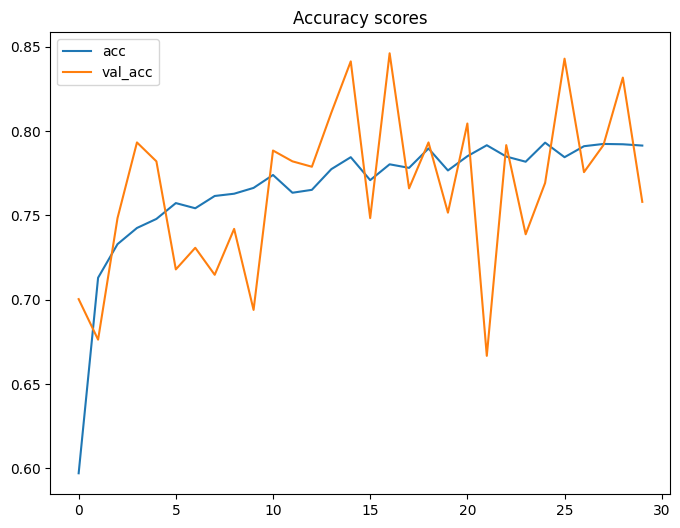

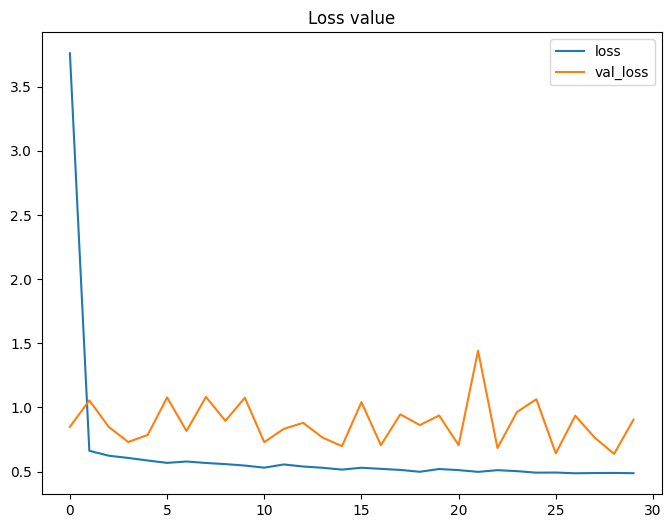

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
predictions = model.predict(X_test)
predictions = one_hot_encoder.inverse_transform(predictions)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
cm = confusion_matrix(y_test, predictions)

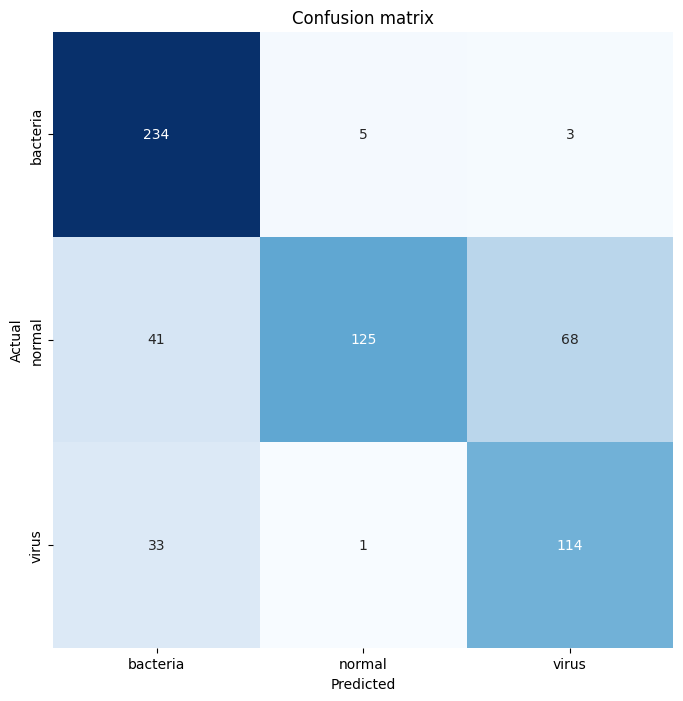

In [ ]:
classnames = ['bacteria', 'normal', 'virus']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Define the path to your dataset
dataset_path = 'path/to/your/dataset'  # Replace with your dataset directory
train_path = 'path/to/save/training_data'
val_path = 'path/to/save/validation_data'

# Create directories for training and validation data
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

# Get the list of all classes (subdirectories in the dataset folder)
classes = os.listdir(dataset_path)

for class_name in classes:
    # Get the path of the current class
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip if it's not a directory

    # Get the list of all files in the class directory
    files = os.listdir(class_path)
    full_paths = [os.path.join(class_path, f) for f in files]

    # Split the files into training and validation sets
    train_files, val_files = train_test_split(full_paths, test_size=0.2, random_state=42)

    # Create subdirectories for the current class in train and validation folders
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_path, class_name), exist_ok=True)

    # Move the files to their respective folders
    for file in train_files:
        shutil.copy(file, os.path.join(train_path, class_name))

    for file in val_files:
        shutil.copy(file, os.path.join(val_path, class_name))

print("Dataset successfully split into training and validation sets.")
